# Conclusion

## ml part:

#### (SIFT+SVM): 67% accuracy, 0.67 recall, 67% precision
#### (LBP+KNN): 48% accuracy, 0.48 recall, 50% precision
#### (SIFT+SVM+preprocessing): 69% accuracy, 0.69 recall, 70% precision
#### (SIFT+SVM+edge construction detection): 50% accuracy, 0.51 recall, 51% precision
### use SIFT+SVM+preprocessing, time saving, gpu saving, around 70% accuracy

## dl part:

### balanced dataset:
#### (resnet18): 97% accuracy, 0.97 recall, 97% precision
#### (efficientnet_b0): 98% accuracy, 0.98 recall, 98% precision

### imbalanced dataset:

#### (resnet18): 91.58% accuracy, 0.90 recall, 91.4% precision
#### (efficientnet): 88.74% accuracy, 0.89 recall, 90.57% precision
#### use resnet18 to improve the performance

#### (resnet18+focalloss+reweighting): 91% accuracy, 0.91 recall, 92% precision
#### (resnet18 + Focal + Dice Loss): 91% accuracy, 0.91 recall, 90% precision
#### (ResNet18 + Augment + Focal + Dice + Sampler): 92.75% accuracy, 0.9282 recall, 92.81% precision
### use ResNet18 + Augment + Focal + Dice + Sampler,better performance on training imbanlanced dataset.

## validation:true(on a new imbalanced dataset and test the performance on resnet18 and ResNet18 + Augment + Focal + Dice + Sampler)

In [1]:
'''SIFT+SVM'''
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

def load_sift_features(image_dir, max_per_class=30):
    sift = cv2.SIFT_create()
    features, labels = [], []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            keypoints, descriptor = sift.detectAndCompute(img, None)
            if descriptor is not None:
                descriptor = descriptor.mean(axis=0) 
                features.append(descriptor)
                labels.append(class_name)
                count += 1
    return np.array(features), np.array(labels)

features, labels = load_sift_features(r'C:\Users\37664\archive\Aerial_Landscapes', max_per_class=200)


X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

print("Classification Report (SIFT + SVM):")
print(classification_report(y_test, y_pred))

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
n_classes = y_test_bin.shape[1]


Classification Report (SIFT + SVM):
              precision    recall  f1-score   support

 Agriculture       0.78      0.95      0.85        40
     Airport       0.52      0.78      0.62        40
       Beach       0.66      0.68      0.67        40
        City       0.78      0.72      0.75        40
      Desert       0.58      0.47      0.52        40
      Forest       0.81      0.88      0.84        40
   Grassland       0.73      0.60      0.66        40
     Highway       0.48      0.62      0.54        40
        Lake       0.46      0.45      0.46        40
    Mountain       0.65      0.70      0.67        40
     Parking       0.97      0.88      0.92        40
        Port       0.79      0.78      0.78        40
     Railway       0.62      0.50      0.56        40
 Residential       0.89      0.82      0.86        40
       River       0.38      0.25      0.30        40

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67 

In [5]:
'''LBP+KNN'''
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern

radius = 1
n_points = 8 * radius

def extract_lbp_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    '''img = cv2.resize(img, (128, 128))'''
    lbp = local_binary_pattern(img, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, n_points + 3),
                             range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  
    return hist

def load_lbp_features(image_dir, max_per_class=30):
    features, labels = [], []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break
            img_path = os.path.join(class_path, file)
            feat = extract_lbp_features(img_path)
            if feat is not None:
                features.append(feat)
                labels.append(class_name)
                count += 1
    return np.array(features), np.array(labels)

features, labels = load_lbp_features(r'C:\Users\37664\archive\Aerial_Landscapes', max_per_class=800)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42)

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report (LBP + kNN):")
print(classification_report(y_test, y_pred))


Classification Report (LBP + kNN):
              precision    recall  f1-score   support

 Agriculture       0.42      0.67      0.52       160
     Airport       0.24      0.34      0.28       160
       Beach       0.33      0.39      0.36       160
        City       0.38      0.53      0.44       160
      Desert       0.51      0.54      0.53       160
      Forest       0.70      0.78      0.74       160
   Grassland       0.66      0.56      0.61       160
     Highway       0.40      0.39      0.40       160
        Lake       0.54      0.47      0.50       160
    Mountain       0.52      0.51      0.52       160
     Parking       0.56      0.36      0.44       160
        Port       0.71      0.62      0.66       160
     Railway       0.60      0.36      0.45       160
 Residential       0.58      0.53      0.55       160
       River       0.32      0.17      0.23       160

    accuracy                           0.48      2400
   macro avg       0.50      0.48      0.48  

SIFT is much better than LBP,so I will try different methods to imporve the behavior of SIFT,respectively denoising and using edge constructive detection.

In [4]:
'''SIFT with preprocessing'''
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def preprocess_image(img):
    '''img = cv2.resize(img, (128, 128))'''                       
    img = cv2.GaussianBlur(img, (3, 3), 0)                  
    img = cv2.equalizeHist(img)                             
    return img

def load_sift_features_preprocessed(image_dir, max_per_class=200):
    sift = cv2.SIFT_create()
    features, labels = [], []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = preprocess_image(img)  
            keypoints, descriptor = sift.detectAndCompute(img, None)
            if descriptor is not None:
                descriptor = descriptor.mean(axis=0) 
                features.append(descriptor)
                labels.append(class_name)
                count += 1
    return np.array(features), np.array(labels)

features_prep, labels_prep = load_sift_features_preprocessed(
    r'C:\Users\37664\archive\Aerial_Landscapes', max_per_class=200)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    features_prep, labels_prep, test_size=0.2, stratify=labels_prep, random_state=42)

clf_p = SVC(kernel='linear')
clf_p.fit(X_train_p, y_train_p)
y_pred_p = clf_p.predict(X_test_p)

print("Classification Report (SIFT + SVM with Preprocessing):")
print(classification_report(y_test_p, y_pred_p))


Classification Report (SIFT + SVM with Preprocessing):
              precision    recall  f1-score   support

 Agriculture       0.73      0.80      0.76        40
     Airport       0.57      0.70      0.63        40
       Beach       0.62      0.65      0.63        40
        City       0.78      0.80      0.79        40
      Desert       0.56      0.57      0.57        40
      Forest       0.75      0.75      0.75        40
   Grassland       0.56      0.62      0.59        40
     Highway       0.71      0.60      0.65        40
        Lake       0.46      0.45      0.46        40
    Mountain       0.78      0.70      0.74        40
     Parking       0.94      0.85      0.89        40
        Port       0.97      0.82      0.89        40
     Railway       0.66      0.78      0.71        40
 Residential       0.86      0.90      0.88        40
       River       0.50      0.38      0.43        40

    accuracy                           0.69       600
   macro avg       0.70  

SIFT is sensetive for high frequency area.So use gaussian filter and histogram equalize improve the performance.

In [7]:
'''SIFT+edge constraction dectection'''
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def load_sift_on_edges(image_dir, max_per_class=200):
    sift = cv2.SIFT_create()
    features, labels = [], []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for file in os.listdir(class_path):
            if count >= max_per_class:
                break
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            '''img = cv2.resize(img, (128, 128))'''
            edge = cv2.Canny(img, 50, 150)  
            keypoints, descriptor = sift.detectAndCompute(edge, None)
            if descriptor is not None:
                descriptor = descriptor.mean(axis=0)
                features.append(descriptor)
                labels.append(class_name)
                count += 1
    return np.array(features), np.array(labels)

features_edge, labels_edge = load_sift_on_edges(
    r'C:\Users\37664\archive\Aerial_Landscapes', max_per_class=200)

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    features_edge, labels_edge, test_size=0.2, stratify=labels_edge, random_state=42)

clf_edge = SVC(kernel='linear')
clf_edge.fit(X_train_e, y_train_e)
y_pred_e = clf_edge.predict(X_test_e)

print("Classification Report (SIFT on Canny Edges + SVM):")
print(classification_report(y_test_e, y_pred_e))

Classification Report (SIFT on Canny Edges + SVM):
              precision    recall  f1-score   support

 Agriculture       0.67      0.72      0.70        40
     Airport       0.36      0.50      0.42        40
       Beach       0.43      0.47      0.45        40
        City       0.41      0.60      0.48        40
      Desert       0.36      0.30      0.33        40
      Forest       0.70      0.75      0.72        40
   Grassland       0.40      0.47      0.43        40
     Highway       0.50      0.35      0.41        40
        Lake       0.39      0.40      0.40        40
    Mountain       0.54      0.53      0.53        40
     Parking       0.72      0.70      0.71        40
        Port       0.66      0.47      0.55        40
     Railway       0.51      0.50      0.51        40
 Residential       0.67      0.60      0.63        40
       River       0.35      0.20      0.25        40

    accuracy                           0.51       600
   macro avg       0.51      

Deeplearning methods

Using device: cuda
Epoch 1/5 - Loss: 124.0210
Epoch 2/5 - Loss: 27.4007
Epoch 3/5 - Loss: 16.1886
Epoch 4/5 - Loss: 8.9887
Epoch 5/5 - Loss: 9.3043
Classification Report (ResNet18):
              precision    recall  f1-score   support

 Agriculture    0.96364   0.97546   0.96951       163
     Airport    0.95484   0.90798   0.93082       163
       Beach    0.96296   0.98734   0.97500       158
        City    0.95804   0.95139   0.95470       144
      Desert    0.91860   0.95758   0.93769       165
      Forest    0.94048   1.00000   0.96933       158
   Grassland    0.98182   0.97590   0.97885       166
     Highway    0.97041   0.93714   0.95349       175
        Lake    0.94969   0.99342   0.97106       152
    Mountain    0.95775   0.89474   0.92517       152
     Parking    0.99310   0.95364   0.97297       151
        Port    0.98101   0.99359   0.98726       156
     Railway    0.94972   0.95506   0.95238       178
 Residential    0.95506   0.98837   0.97143       172
       

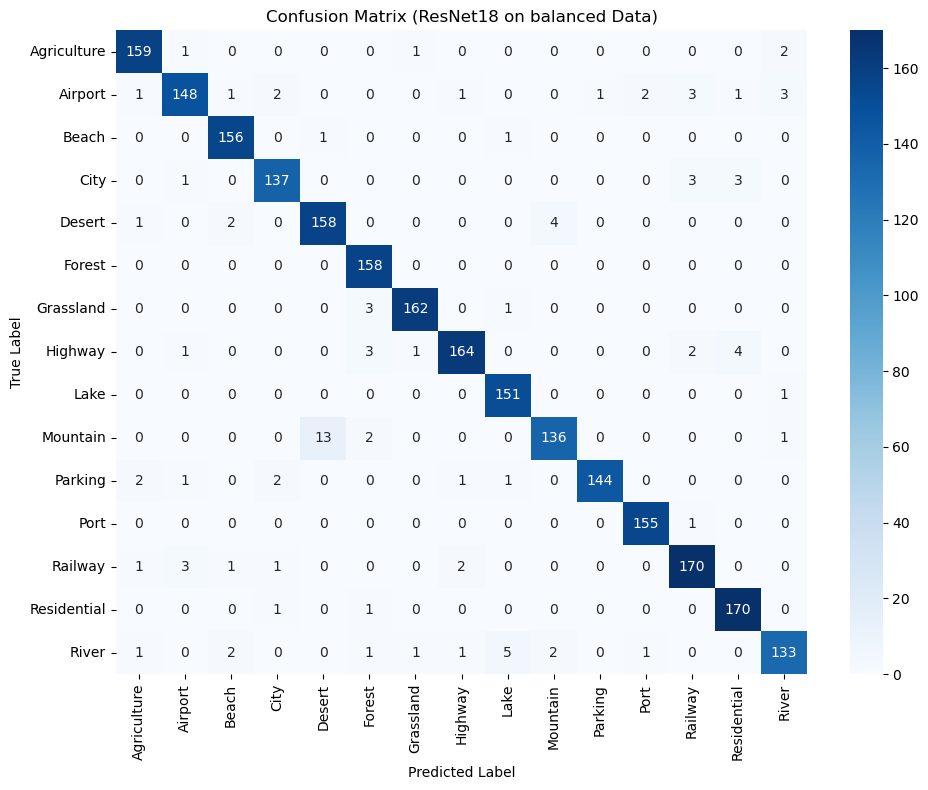

In [4]:
'''resnet18'''
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = dataset.classes
print("Classification Report (ResNet18):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix (balanced dataset with regular resnet18):")
print(cm_df)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet18 on balanced Data)")
plt.tight_layout()
plt.show()

Using device: cuda
Epoch 1/5 - Loss: 264.8120
Epoch 2/5 - Loss: 54.4225
Epoch 3/5 - Loss: 30.7587
Epoch 4/5 - Loss: 21.0125
Epoch 5/5 - Loss: 15.3708
Classification Report (EfficientNet_b0):
              precision    recall  f1-score   support

 Agriculture    0.99351   0.98077   0.98710       156
     Airport    0.98077   0.98077   0.98077       156
       Beach    0.97516   0.99367   0.98433       158
        City    0.96875   0.99359   0.98101       156
      Desert    0.96970   0.97561   0.97264       164
      Forest    0.99375   0.97546   0.98452       163
   Grassland    0.98235   1.00000   0.99110       167
     Highway    0.97516   0.99367   0.98433       158
        Lake    0.97887   0.92053   0.94881       151
    Mountain    0.97024   0.96450   0.96736       169
     Parking    0.99363   1.00000   0.99681       156
        Port    0.98810   0.98225   0.98516       169
     Railway    0.98726   0.97484   0.98101       159
 Residential    1.00000   0.99359   0.99678       15

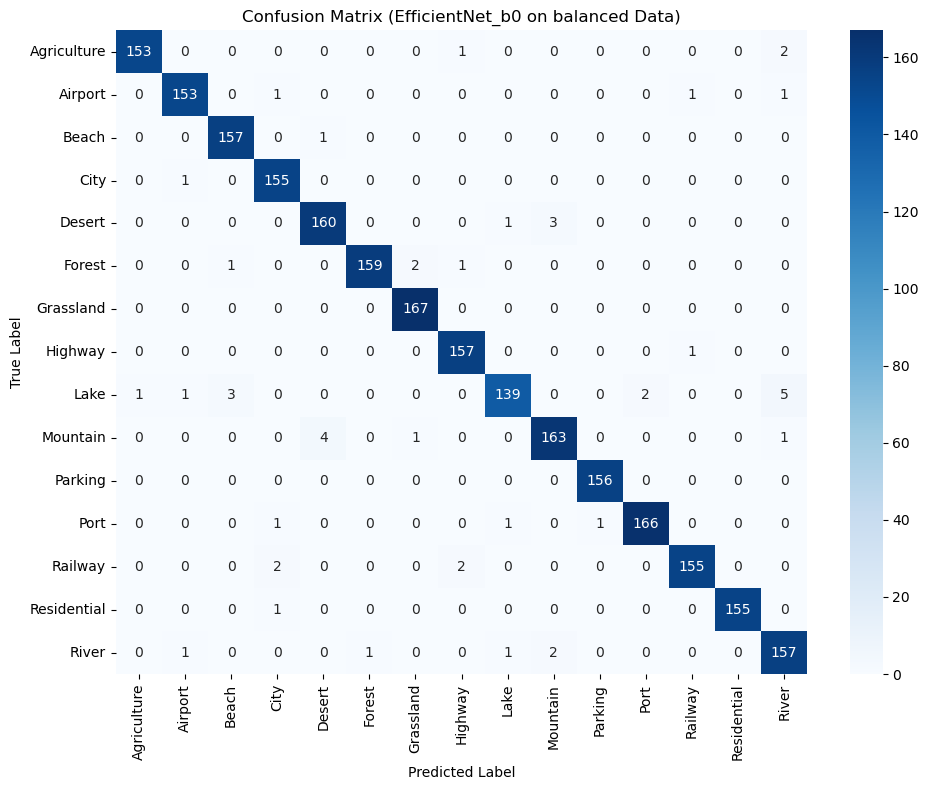

In [3]:
'''effientnet'''
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

weights = EfficientNet_B0_Weights.DEFAULT
preprocess = weights.transforms()

data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model = efficientnet_b0(weights=weights)
num_classes = len(dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = dataset.classes
print("Classification Report (EfficientNet_b0):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
'''cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix (balanced dataset with EfficientNet_b0):")
print(cm_df)'''

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (EfficientNet_b0 on balanced Data)")
plt.tight_layout()
plt.show()


Using: cuda
[Epoch 1] Training Loss: 50.3940
[Epoch 2] Training Loss: 8.3641
[Epoch 3] Training Loss: 4.5264
[Epoch 4] Training Loss: 2.6452
[Epoch 5] Training Loss: 1.6161
Classification Report (ResNet18 trained on imbalanced data):
              precision    recall  f1-score   support

 Agriculture    0.85326   0.98742   0.91545       159
     Airport    0.69903   0.96644   0.81127       149
       Beach    0.92896   0.95506   0.94183       178
        City    0.95918   0.86503   0.90968       163
      Desert    0.94578   0.98125   0.96319       160
      Forest    0.90141   0.90141   0.90141       142
   Grassland    0.92265   0.96532   0.94350       173
     Highway    0.98621   0.91667   0.95017       156
        Lake    0.89634   0.85465   0.87500       172
    Mountain    0.92896   0.94972   0.93923       179
     Parking    0.98571   0.95172   0.96842       145
        Port    0.96795   0.91515   0.94081       165
     Railway    0.87692   0.80851   0.84133       141
 Resident

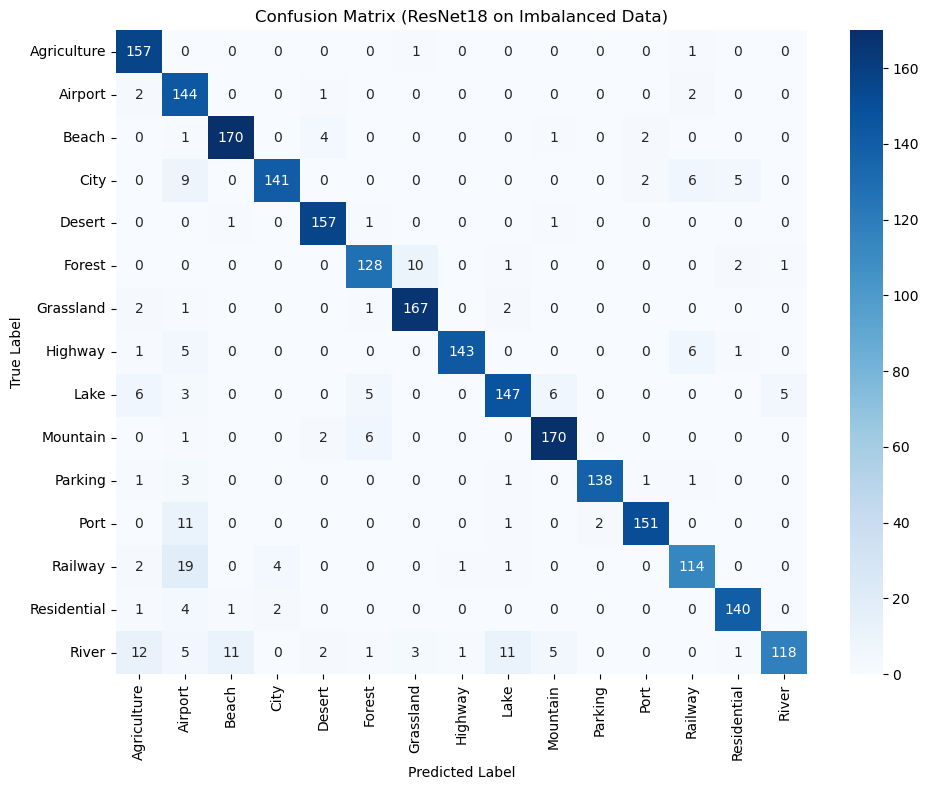

In [5]:
'''resnet18 in imbalanced dataset(without preprocessing)'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [500, 300] + [70]*12 + [30])}

imbal_train_indices = []
for cls, indices in class_to_indices.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (ResNet18 trained on imbalanced data):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix (inbalanced dataset with regular resnet18):")
print(cm_df)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet18 on Imbalanced Data)")
plt.tight_layout()
plt.show()

Using: cpu
[Epoch 1] Training Loss: 108.1358
[Epoch 2] Training Loss: 57.1749
[Epoch 3] Training Loss: 29.0671
[Epoch 4] Training Loss: 16.2387
[Epoch 5] Training Loss: 10.7450
Classification Report (EfficientNet_b0 on Imbalanced Data):
              precision    recall  f1-score   support

 Agriculture    0.81250   0.98113   0.88889       159
     Airport    0.69524   0.97987   0.81337       149
       Beach    0.91444   0.96067   0.93699       178
        City    0.95513   0.91411   0.93417       163
      Desert    0.95062   0.96250   0.95652       160
      Forest    0.89032   0.97183   0.92929       142
   Grassland    0.97561   0.92486   0.94955       173
     Highway    0.95364   0.92308   0.93811       156
        Lake    0.77041   0.87791   0.82065       172
    Mountain    0.89474   0.94972   0.92141       179
     Parking    0.98582   0.95862   0.97203       145
        Port    0.94156   0.87879   0.90909       165
     Railway    0.89051   0.86525   0.87770       141
 Resid

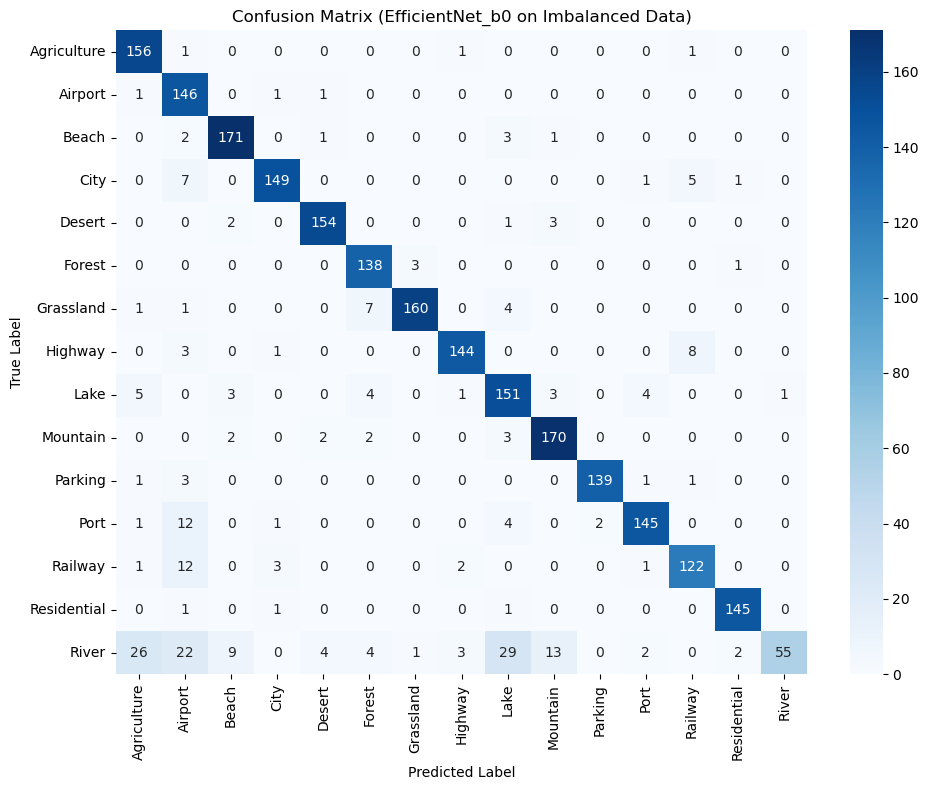

In [15]:
'''efficientnet on imbalanced dataset'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = EfficientNet_B0_Weights.DEFAULT
preprocess = weights.transforms()

data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [500, 300] + [70]*12 + [30])}
imbal_train_indices = []
for cls, indices in class_to_indices.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = efficientnet_b0(weights=weights)
num_classes = len(full_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (EfficientNet_b0 on Imbalanced Data):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
'''cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(cm_df)'''

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (EfficientNet_b0 on Imbalanced Data)")
plt.tight_layout()
plt.show()


**Focus on resnet18 to improve the performance**
**efficientnet has lower recall on imbalanced features**

Using: cuda
[Epoch 1] Training Loss: 661.1877
[Epoch 2] Training Loss: 87.2132
[Epoch 3] Training Loss: 35.3653
[Epoch 4] Training Loss: 16.2947
[Epoch 5] Training Loss: 10.6286
Classification Report (ResNet18 + Focal Loss + Reweighting):
              precision    recall  f1-score   support

 Agriculture    0.93413   0.98113   0.95706       159
     Airport    0.76882   0.95973   0.85373       149
       Beach    0.96951   0.89326   0.92982       178
        City    0.94771   0.88957   0.91772       163
      Desert    0.95706   0.97500   0.96594       160
      Forest    0.87975   0.97887   0.92667       142
   Grassland    0.97590   0.93642   0.95575       173
     Highway    0.94631   0.90385   0.92459       156
        Lake    0.82000   0.95349   0.88172       172
    Mountain    0.95556   0.96089   0.95822       179
     Parking    0.93333   0.96552   0.94915       145
        Port    0.96226   0.92727   0.94444       165
     Railway    0.89147   0.81560   0.85185       141
 Res

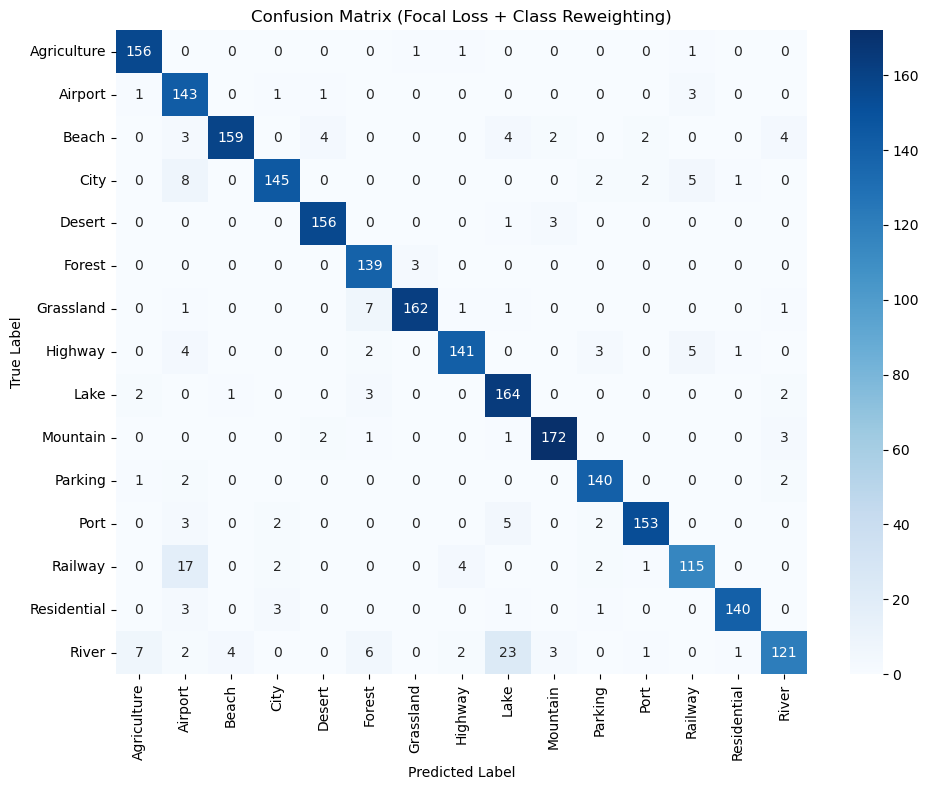

In [1]:
'''ResNet18 + Focal Loss + Reweighting'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [500, 300] + [70]*12 + [30])}
imbal_train_indices = []
for cls, indices in class_to_indices.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

imbal_labels = [full_dataset.targets[i] for i in imbal_train_indices]
label_counts = Counter(imbal_labels)
total = sum(label_counts.values())

class_weights = []
for i in range(15):
    freq = label_counts[i] if i in label_counts else 1
    class_weights.append(total / freq)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

def focal_loss(outputs, targets, alpha=None, gamma=1.5):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    alpha_t = alpha[targets] if alpha is not None else 1.0
    return (alpha_t * (1 - pt) ** gamma * ce_loss).mean()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = focal_loss(outputs, labels, alpha=class_weights, gamma=2.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (ResNet18 + Focal Loss + Reweighting):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
'''print("Confusion Matrix:")
print(cm_df)'''

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Focal Loss + Class Reweighting)")
plt.tight_layout()
plt.show()



Using: cuda
[Epoch 1] Training Loss: 709.6408
[Epoch 2] Training Loss: 94.7640
[Epoch 3] Training Loss: 37.2944
[Epoch 4] Training Loss: 29.0167
[Epoch 5] Training Loss: 21.4952
Classification Report (Focal + Dice Loss):
              precision    recall  f1-score   support

 Agriculture    0.92073   0.94969   0.93498       159
     Airport    0.77901   0.94631   0.85455       149
       Beach    0.93220   0.92697   0.92958       178
        City    0.95000   0.93252   0.94118       163
      Desert    0.97987   0.91250   0.94498       160
      Forest    0.97674   0.88732   0.92989       142
   Grassland    0.92737   0.95954   0.94318       173
     Highway    0.92903   0.92308   0.92605       156
        Lake    0.89535   0.89535   0.89535       172
    Mountain    0.78924   0.98324   0.87562       179
     Parking    0.95890   0.96552   0.96220       145
        Port    0.98639   0.87879   0.92949       165
     Railway    0.90152   0.84397   0.87179       141
 Residential    0.9718

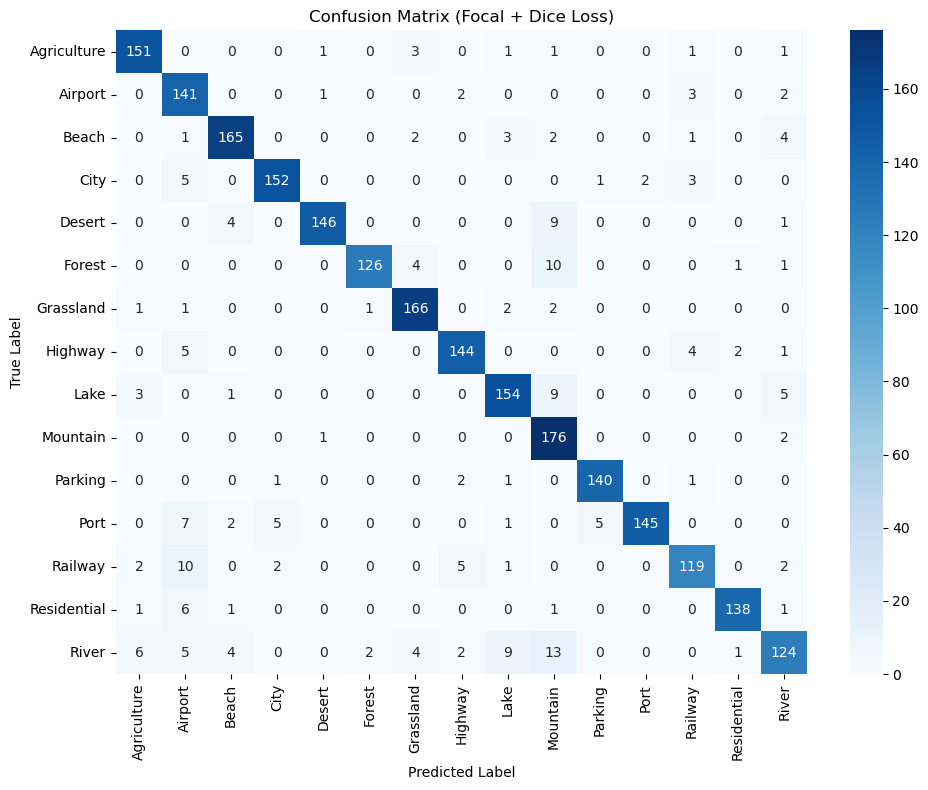

In [2]:
'''resnet18 + Focal + Dice Loss'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [500, 300] + [70]*12 + [30])}
imbal_train_indices = []
for cls, indices in class_to_indices.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

imbal_labels = [full_dataset.targets[i] for i in imbal_train_indices]
label_counts = Counter(imbal_labels)
total = sum(label_counts.values())
class_weights = []
for i in range(15):
    freq = label_counts[i] if i in label_counts else 1
    class_weights.append(total / freq)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

def focal_loss(outputs, targets, alpha=None, gamma=2.0):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    alpha_t = alpha[targets] if alpha is not None else 1.0
    return (alpha_t * (1 - pt) ** gamma * ce_loss).mean()

def dice_loss(outputs, targets, smooth=1e-5):
    num_classes = outputs.size(1)
    outputs = F.softmax(outputs, dim=1)  # [B, C]

    targets_onehot = F.one_hot(targets, num_classes=num_classes).float()  # [B, C]

    intersection = (outputs * targets_onehot).sum(dim=0)
    union = outputs.sum(dim=0) + targets_onehot.sum(dim=0)

    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


optimizer = optim.Adam(model.parameters(), lr=1e-4)

lambda_focal = 1.0
lambda_dice = 0.5

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)

        loss_focal = focal_loss(outputs, labels, alpha=class_weights, gamma=1.5)
        loss_dice = dice_loss(outputs, labels)
        loss = lambda_focal * loss_focal + lambda_dice * loss_dice

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (Focal + Dice Loss):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
'''print("Confusion Matrix:")
print(cm_df)'''

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Focal + Dice Loss)")
plt.tight_layout()
plt.show()


**SOLUTION ON IMBALANCED DATASET**

Using: cpu
[Epoch 1] Training Loss: 55.5601
[Epoch 2] Training Loss: 14.7504
[Epoch 3] Training Loss: 10.7610
[Epoch 4] Training Loss: 11.6139
[Epoch 5] Training Loss: 9.3115
Classification Report (ResNet18 + Augment + Focal + Dice + Sampler):
              precision    recall  f1-score   support

 Agriculture    0.92683   0.95597   0.94118       159
     Airport    0.85526   0.87248   0.86379       149
       Beach    0.93407   0.95506   0.94444       178
        City    0.94479   0.94479   0.94479       163
      Desert    0.93333   0.96250   0.94769       160
      Forest    0.91946   0.96479   0.94158       142
   Grassland    0.95429   0.96532   0.95977       173
     Highway    0.95946   0.91026   0.93421       156
        Lake    0.96341   0.91860   0.94048       172
    Mountain    0.88205   0.96089   0.91979       179
     Parking    0.96575   0.97241   0.96907       145
        Port    0.95732   0.95152   0.95441       165
     Railway    0.83544   0.93617   0.88294       141

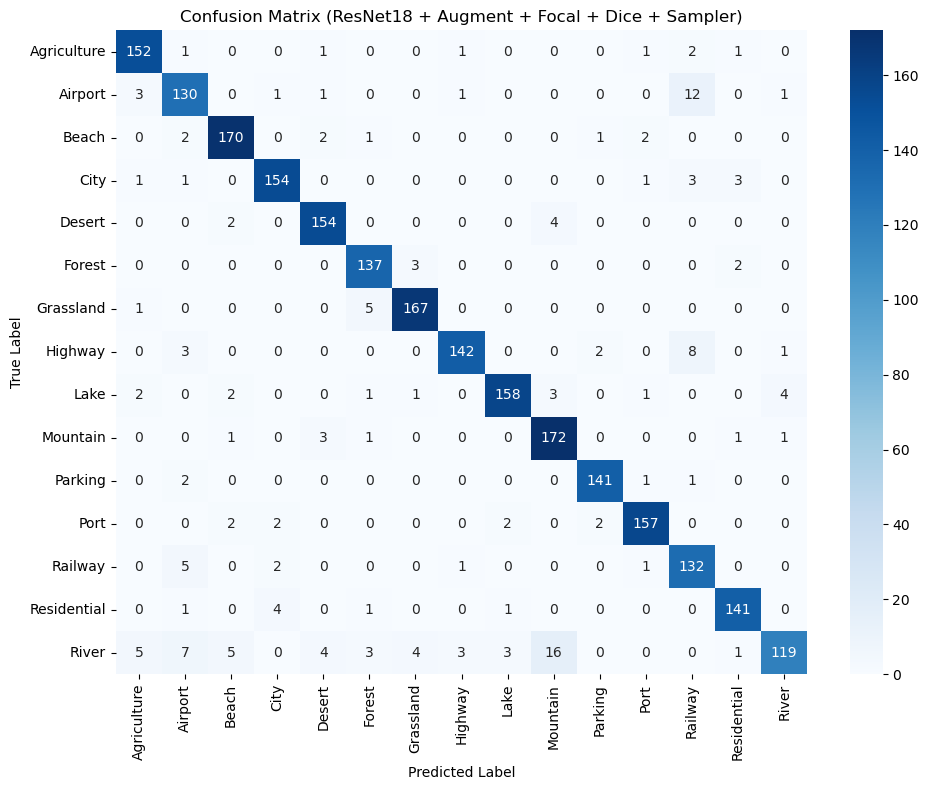

In [11]:
'''A solution to fix imbalanced dataset'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = ResNet18_Weights.DEFAULT
image_size = weights.transforms().crop_size[0]
mean = [0.485, 0.456, 0.406]  # R, G, B
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)

preprocess = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    normalize
])

data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices_map = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices_map[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [500, 300] + [70]*12 + [30])}
imbal_train_indices = []
for cls, indices in class_to_indices_map.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

imbal_labels = [full_dataset.targets[i] for i in imbal_train_indices]
label_counts = Counter(imbal_labels)
class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
sample_weights = [class_weights[label] for label in imbal_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

def focal_loss(outputs, targets, gamma=2.0):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    return ((1 - pt) ** gamma * ce_loss).mean()

def dice_loss(outputs, targets, smooth=1e-5):
    num_classes = outputs.size(1)
    outputs = F.softmax(outputs, dim=1)
    targets_onehot = F.one_hot(targets, num_classes).float()
    intersection = (outputs * targets_onehot).sum(dim=0)
    union = outputs.sum(dim=0) + targets_onehot.sum(dim=0)
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
lambda_focal = 1.0
lambda_dice = 0.5

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss_f = focal_loss(outputs, labels)
        loss_d = dice_loss(outputs, labels)
        loss = lambda_focal * loss_f + lambda_dice * loss_d
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (ResNet18 + Augment + Focal + Dice + Sampler):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(cm_df)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet18 + Augment + Focal + Dice + Sampler)")
plt.tight_layout()
plt.show()


**Recall on small number features improved,total f1 score imporved,total accuracy improved**

**VALID on a new imbalanced dataset**

Using: cuda
[Epoch 1] Training Loss: 58.6764
[Epoch 2] Training Loss: 10.3076
[Epoch 3] Training Loss: 3.6446
[Epoch 4] Training Loss: 1.9934
[Epoch 5] Training Loss: 1.5638
Classification Report (ResNet18 trained on imbalanced data):
              precision    recall  f1-score   support

 Agriculture    0.90643   0.97484   0.93939       159
     Airport    0.69340   0.98658   0.81440       149
       Beach    0.90256   0.98876   0.94370       178
        City    0.88824   0.92638   0.90691       163
      Desert    0.96273   0.96875   0.96573       160
      Forest    0.90260   0.97887   0.93919       142
   Grassland    0.93370   0.97688   0.95480       173
     Highway    0.96078   0.94231   0.95146       156
        Lake    0.85955   0.88953   0.87429       172
    Mountain    0.90860   0.94413   0.92603       179
     Parking    0.97183   0.95172   0.96167       145
        Port    0.99315   0.87879   0.93248       165
     Railway    0.93519   0.71631   0.81124       141
 Residen

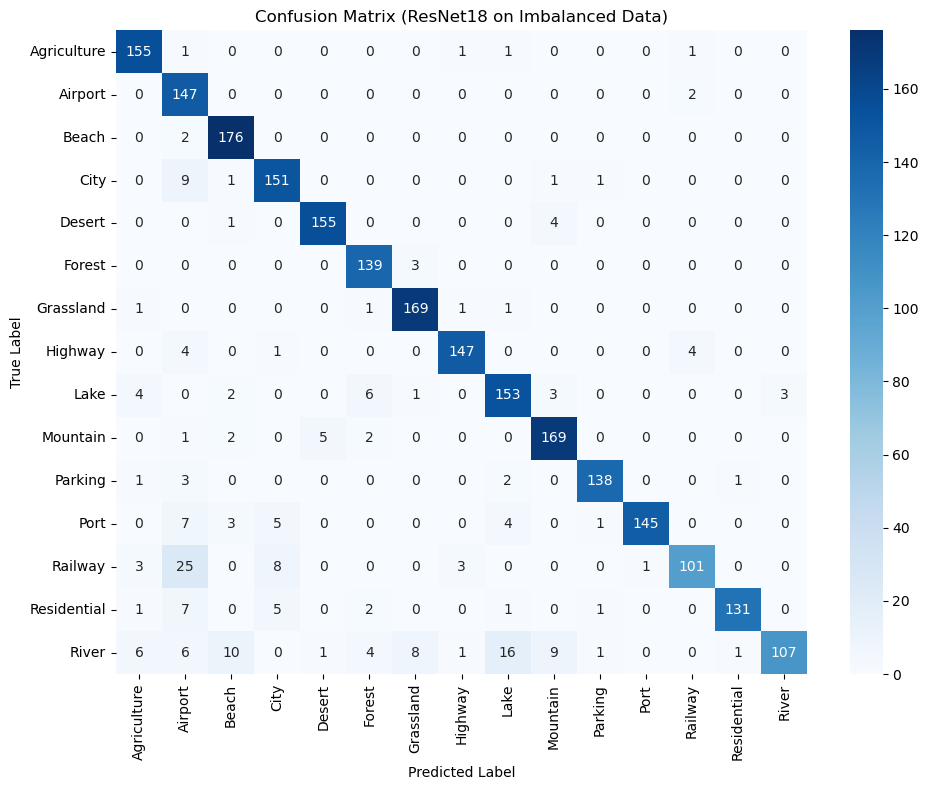

In [1]:
'''resnet18 in imbalanced dataset(without preprocessing)'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [600, 320] + [213] + [160,128,106,91,80,71,64,58,53,49,45,42])}

imbal_train_indices = []
for cls, indices in class_to_indices.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (ResNet18 trained on imbalanced data):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix (inbalanced dataset with regular resnet18):")
print(cm_df)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet18 on Imbalanced Data)")
plt.tight_layout()
plt.show()

Using: cuda
[Epoch 1] Training Loss: 58.8394
[Epoch 2] Training Loss: 15.6785
[Epoch 3] Training Loss: 10.7196
[Epoch 4] Training Loss: 10.1183
[Epoch 5] Training Loss: 8.1421
Classification Report (ResNet18 + Augment + Focal + Dice + Sampler):
              precision    recall  f1-score   support

 Agriculture    0.93252   0.95597   0.94410       159
     Airport    0.81287   0.93289   0.86875       149
       Beach    0.93370   0.94944   0.94150       178
        City    0.88571   0.95092   0.91716       163
      Desert    0.92442   0.99375   0.95783       160
      Forest    0.93243   0.97183   0.95172       142
   Grassland    0.92222   0.95954   0.94051       173
     Highway    0.94737   0.92308   0.93506       156
        Lake    0.91860   0.91860   0.91860       172
    Mountain    0.93785   0.92737   0.93258       179
     Parking    0.97887   0.95862   0.96864       145
        Port    0.97386   0.90303   0.93711       165
     Railway    0.91852   0.87943   0.89855       14

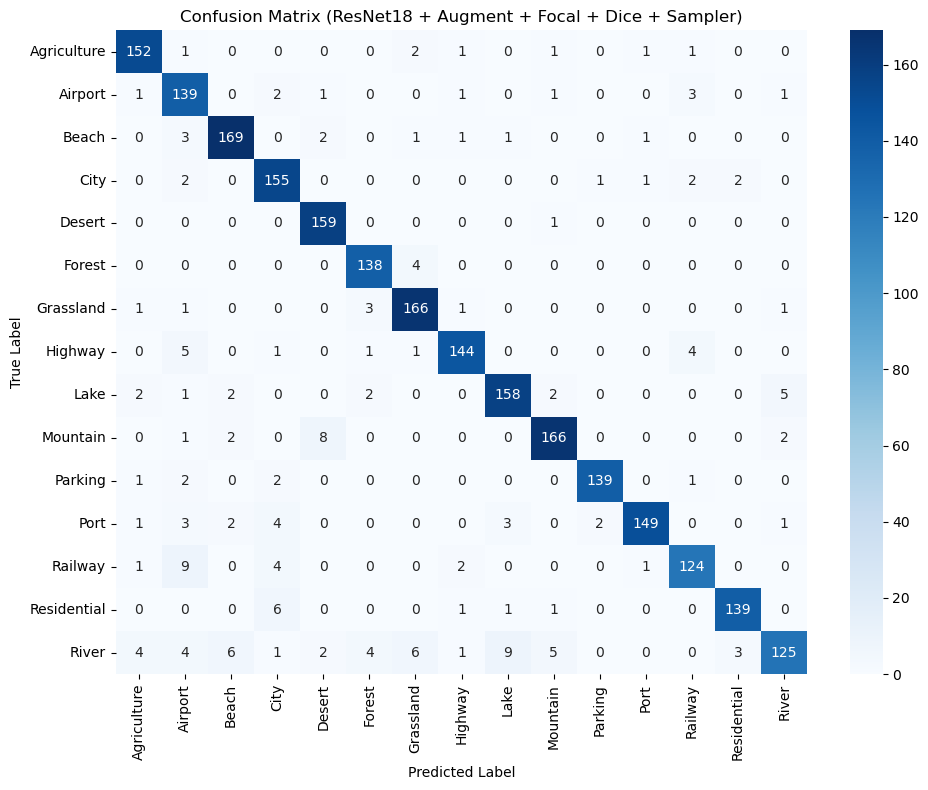

In [2]:
'''A solution to fix imbalanced dataset'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = ResNet18_Weights.DEFAULT
image_size = weights.transforms().crop_size[0]
mean = [0.485, 0.456, 0.406]  # R, G, B
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)

preprocess = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    normalize
])

data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices_map = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices_map[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [600, 320] + [213] + [160,128,106,91,80,71,64,58,53,49,45,42])}
imbal_train_indices = []
for cls, indices in class_to_indices_map.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

imbal_labels = [full_dataset.targets[i] for i in imbal_train_indices]
label_counts = Counter(imbal_labels)
class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
sample_weights = [class_weights[label] for label in imbal_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

def focal_loss(outputs, targets, gamma=2.0):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    return ((1 - pt) ** gamma * ce_loss).mean()

def dice_loss(outputs, targets, smooth=1e-5):
    num_classes = outputs.size(1)
    outputs = F.softmax(outputs, dim=1)
    targets_onehot = F.one_hot(targets, num_classes).float()
    intersection = (outputs * targets_onehot).sum(dim=0)
    union = outputs.sum(dim=0) + targets_onehot.sum(dim=0)
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
lambda_focal = 1.0
lambda_dice = 0.5

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss_f = focal_loss(outputs, labels)
        loss_d = dice_loss(outputs, labels)
        loss = lambda_focal * loss_f + lambda_dice * loss_d
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (ResNet18 + Augment + Focal + Dice + Sampler):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(cm_df)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet18 + Augment + Focal + Dice + Sampler)")
plt.tight_layout()
plt.show()


**The f1-score on imbalanced feature(the third one): improved**

**Total accuracy: improved**

**Total f1-score: improved**

Using: cuda
[Epoch 1] Training Loss: 38.5214
[Epoch 2] Training Loss: 6.8980
[Epoch 3] Training Loss: 2.7299
[Epoch 4] Training Loss: 1.7147
[Epoch 5] Training Loss: 0.8298
Classification Report (ResNet18 trained on imbalanced data):
              precision    recall  f1-score   support

 Agriculture    0.67660   1.00000   0.80711       159
     Airport    0.52920   0.97315   0.68558       149
       Beach    0.71605   0.97753   0.82660       178
        City    0.70222   0.96933   0.81443       163
      Desert    0.93529   0.99375   0.96364       160
      Forest    0.79651   0.96479   0.87261       142
   Grassland    0.94048   0.91329   0.92669       173
     Highway    0.93151   0.87179   0.90066       156
        Lake    0.74390   0.70930   0.72619       172
    Mountain    0.92025   0.83799   0.87719       179
     Parking    0.95745   0.93103   0.94406       145
        Port    0.96581   0.68485   0.80142       165
     Railway    0.95312   0.43262   0.59512       141
 Resident

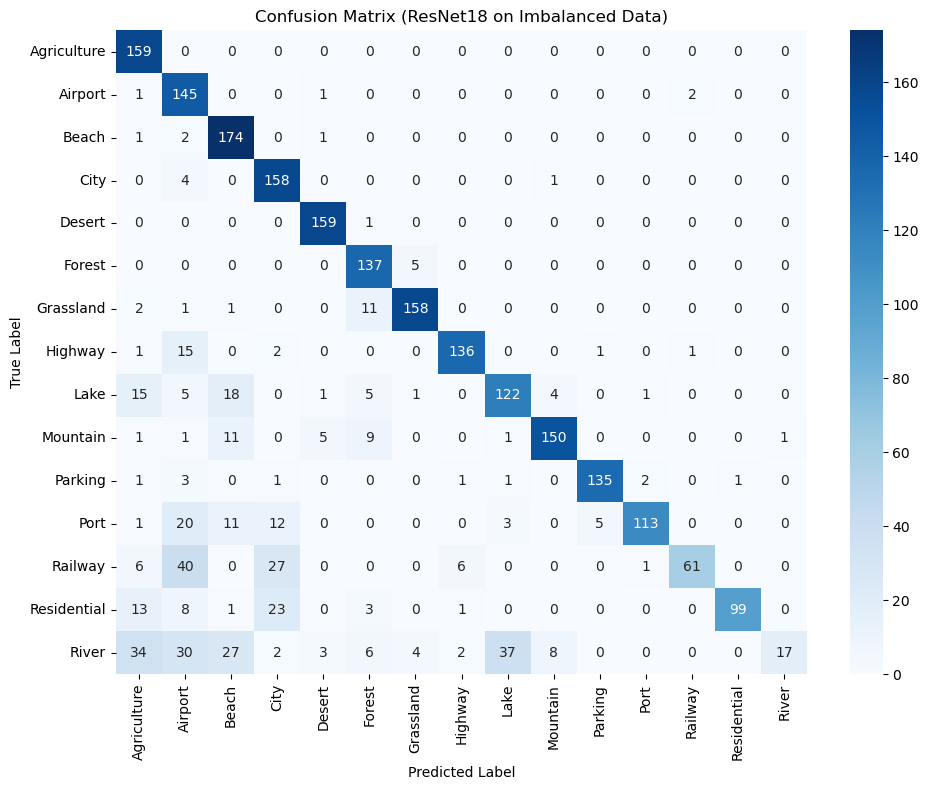

In [3]:
'''resnet18 in imbalanced dataset(without preprocessing)'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()
data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [640, 226] + [123] + [80,57,43,34,28,23,20,17,15,13,12,11])}

imbal_train_indices = []
for cls, indices in class_to_indices.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (ResNet18 trained on imbalanced data):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix (inbalanced dataset with regular resnet18):")
print(cm_df)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet18 on Imbalanced Data)")
plt.tight_layout()
plt.show()

Using: cuda
[Epoch 1] Training Loss: 44.8924
[Epoch 2] Training Loss: 9.1915
[Epoch 3] Training Loss: 5.4082
[Epoch 4] Training Loss: 5.0781
[Epoch 5] Training Loss: 3.8831
Classification Report (ResNet18 + Augment + Focal + Dice + Sampler):
              precision    recall  f1-score   support

 Agriculture    0.82888   0.97484   0.89595       159
     Airport    0.59167   0.95302   0.73008       149
       Beach    0.80556   0.97753   0.88325       178
        City    0.70909   0.95706   0.81462       163
      Desert    0.96732   0.92500   0.94569       160
      Forest    0.93836   0.96479   0.95139       142
   Grassland    0.96951   0.91908   0.94362       173
     Highway    0.89313   0.75000   0.81533       156
        Lake    0.87195   0.83140   0.85119       172
    Mountain    0.89730   0.92737   0.91209       179
     Parking    0.94928   0.90345   0.92580       145
        Port    0.98571   0.83636   0.90492       165
     Railway    0.84043   0.56028   0.67234       141
 

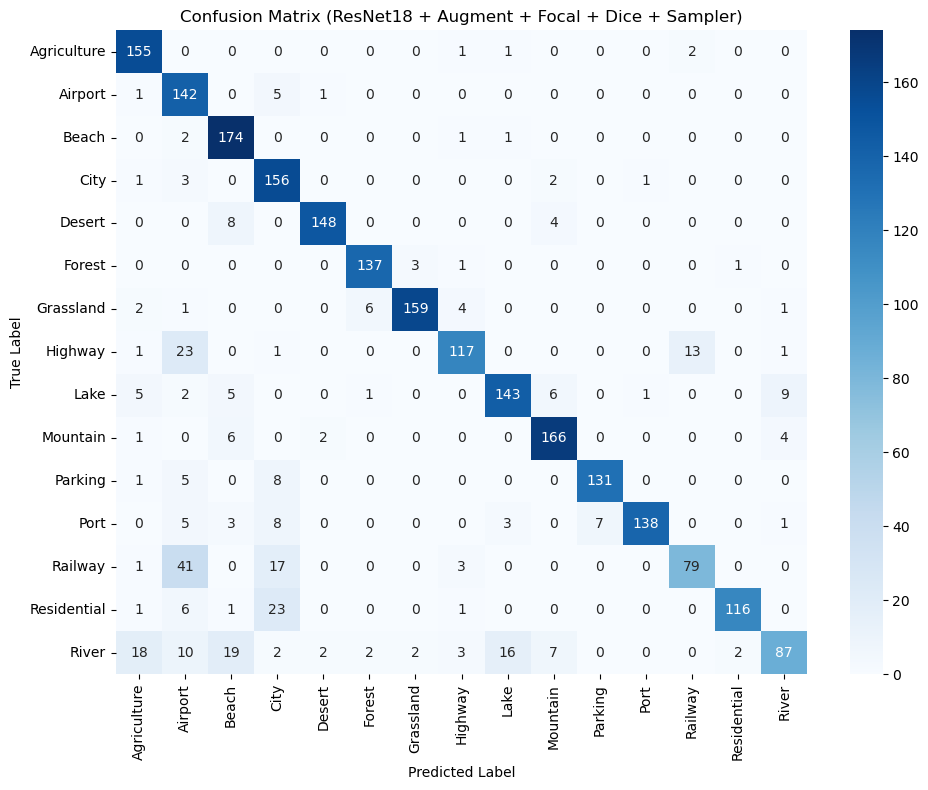

In [4]:
'''A solution to fix imbalanced dataset'''
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

weights = ResNet18_Weights.DEFAULT
image_size = weights.transforms().crop_size[0]
mean = [0.485, 0.456, 0.406]  # R, G, B
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)

preprocess = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    normalize
])

data_dir = r"C:\Users\37664\archive\Aerial_Landscapes"
full_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_full, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_targets = [full_dataset.targets[i] for i in train_full.indices]
class_to_indices_map = defaultdict(list)
for idx, label in zip(train_full.indices, train_targets):
    class_to_indices_map[label].append(idx)

keep_counts = {cls: count for cls, count in zip(range(15), [640, 226] + [123] + [80,57,43,34,28,23,20,17,15,13,12,11])}
imbal_train_indices = []
for cls, indices in class_to_indices_map.items():
    sample_count = min(keep_counts.get(cls, 100), len(indices))
    sampled = random.sample(indices, sample_count)
    imbal_train_indices.extend(sampled)

imbal_train_dataset = Subset(full_dataset, imbal_train_indices)

imbal_labels = [full_dataset.targets[i] for i in imbal_train_indices]
label_counts = Counter(imbal_labels)
class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
sample_weights = [class_weights[label] for label in imbal_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(imbal_train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 15)
model = model.to(device)

def focal_loss(outputs, targets, gamma=2.0):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    return ((1 - pt) ** gamma * ce_loss).mean()

def dice_loss(outputs, targets, smooth=1e-5):
    num_classes = outputs.size(1)
    outputs = F.softmax(outputs, dim=1)
    targets_onehot = F.one_hot(targets, num_classes).float()
    intersection = (outputs * targets_onehot).sum(dim=0)
    union = outputs.sum(dim=0) + targets_onehot.sum(dim=0)
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
lambda_focal = 1.0
lambda_dice = 0.5

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss_f = focal_loss(outputs, labels)
        loss_d = dice_loss(outputs, labels)
        loss = lambda_focal * loss_f + lambda_dice * loss_d
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Training Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = full_dataset.classes
print("Classification Report (ResNet18 + Augment + Focal + Dice + Sampler):")
print(classification_report(y_true, y_pred, target_names=class_names,digits = 5))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(cm_df)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet18 + Augment + Focal + Dice + Sampler)")
plt.tight_layout()
plt.show()


# Conclusion

## ml part:

#### (SIFT+SVM): 67% accuracy, 0.67 recall, 67% precision
#### (LBP+KNN): 48% accuracy, 0.48 recall, 50% precision
#### (SIFT+SVM+preprocessing): 69% accuracy, 0.69 recall, 70% precision
#### (SIFT+SVM+edge construction detection): 50% accuracy, 0.51 recall, 51% precision
### use SIFT+SVM+preprocessing, time saving, gpu saving, around 70% accuracy

## dl part:

### balanced dataset:
#### (resnet18): 97% accuracy, 0.97 recall, 97% precision
#### (efficientnet_b0): 98% accuracy, 0.98 recall, 98% precision

### imbalanced dataset:

#### (resnet18): 91.58% accuracy, 0.90 recall, 91.4% precision
#### (efficientnet): 88.74% accuracy, 0.89 recall, 90.57% precision
#### use resnet18 to improve the performance

#### (resnet18+focalloss+reweighting): 91% accuracy, 0.91 recall, 92% precision
#### (resnet18 + Focal + Dice Loss): 91% accuracy, 0.91 recall, 90% precision
#### (ResNet18 + Augment + Focal + Dice + Sampler): 92.75% accuracy, 0.9282 recall, 92.81% precision
### use ResNet18 + Augment + Focal + Dice + Sampler,better performance on training imbanlanced dataset.

## validation:true(on a new imbalanced dataset and test the performance on resnet18 and ResNet18 + Augment + Focal + Dice + Sampler)

In [1]:
!nvidia-smi

Fri Apr 18 21:21:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.07                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P8              3W /   95W |    1622MiB /   8188MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

CUDA available: True
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (2449.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-win_amd64.whl (4.1 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
